<a href="https://colab.research.google.com/github/NampllayNihal/creditcardproject/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

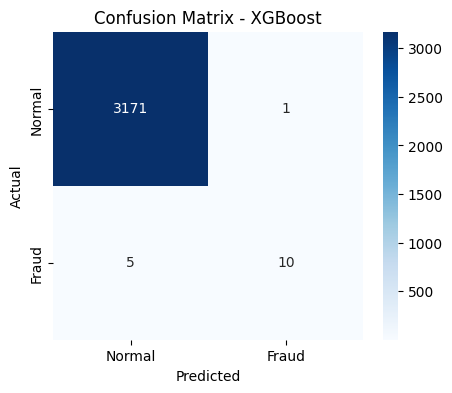

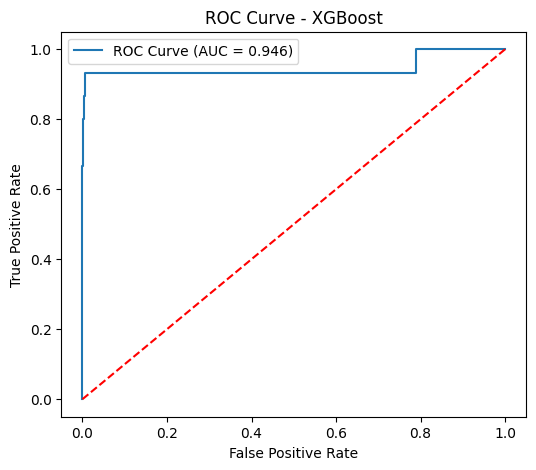

In [2]:
# 📌 Credit Card Fraud Detection Notebook
# Author: Nihal Nampally
# B.Tech AI & ML (2023–2027)

# ========================
# 1. Import Libraries
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier

# ========================
# 2. Load Dataset
# ========================
df = pd.read_csv("creditcard.csv")   # Kaggle dataset
print(df.head())
print(df['Class'].value_counts())

# ========================
# 3. Preprocessing
# ========================
# Drop rows with NaN values in the 'Class' column
df.dropna(subset=['Class'], inplace=True)

# Scale Amount & Time
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Features & Target
X = df.drop('Class', axis=1)
y = df['Class']

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ========================
# 4. Anomaly Detection
# ========================
print("\n🔹 Isolation Forest")
iso = IsolationForest(contamination=0.001, random_state=42)
y_pred_iso = iso.fit_predict(X_test)
y_pred_iso = [1 if p == -1 else 0 for p in y_pred_iso]  # Map -1 → Fraud, 1 → Normal
print(confusion_matrix(y_test, y_pred_iso))

print("\n🔹 Local Outlier Factor")
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.001)
y_pred_lof = lof.fit_predict(X_test)
y_pred_lof = [1 if p == -1 else 0 for p in y_pred_lof]
print(confusion_matrix(y_test, y_pred_lof))

# ========================
# 5. XGBoost Classifier
# ========================
xgb = XGBClassifier(
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:,1]

print("\n🔹 Classification Report (XGBoost)")
print(classification_report(y_test, y_pred))

# ========================
# 6. Confusion Matrix
# ========================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal","Fraud"], yticklabels=["Normal","Fraud"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# Create the 'assets' directory if it doesn't exist
os.makedirs('assets', exist_ok=True)
plt.savefig("assets/confusion_matrix.png")
plt.show()

# ========================
# 7. ROC Curve
# ========================
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
# Create the 'assets' directory if it doesn't exist
os.makedirs('assets', exist_ok=True)
plt.savefig("assets/roc_curve.png")
plt.show()